# Autoencoder

 A CCN based autoencoder.

 Steps:

 1. build an autoencoder
 2. cluster code

## Load dataset

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras_utils

In [2]:
def load_dataset():
    data = pd.read_csv("./datasets/our2/dataset_50_2.5.csv", header=None, names=range(750))
    labels = pd.read_csv("./datasets/our2/dataset_labels_50_2.5.csv", header=None, names=["user", "model", "label"])

    return data, labels

In [3]:
def print_stats(ds: pd.DataFrame):
    print("Shape", ds.shape)
    print("Columns", ds.columns)

In [4]:
X_df, y_df = load_dataset()

In [5]:
print_stats(X_df)
print_stats(y_df)

Shape (22589, 750)
Columns Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            740, 741, 742, 743, 744, 745, 746, 747, 748, 749],
           dtype='int64', length=750)
Shape (22589, 3)
Columns Index(['user', 'model', 'label'], dtype='object')


## Preprocessing

In [6]:
def get_label(x):
    return x[2]

In [7]:
def restructure(x):
    return x.reshape(-1, 6, 125)

In [8]:
def plot_acc(x):
    plt.plot(x[0])
    plt.plot(x[1])
    plt.plot(x[2])

def plot_gyro(x):
    plt.plot(x[3])
    plt.plot(x[4])
    plt.plot(x[5])

def plot_sensors(x):
    plt.subplot(1, 2, 1)
    plot_acc(x)
    plt.subplot(1, 2, 2)
    plot_gyro(x)

In [9]:
def normalize(x):
    min_val = np.max(x)
    max_val = np.min(x)
    
    x = (x - min_val) / (max_val - min_val)
    
    return x

In [10]:
from sklearn import model_selection # import train_test_split

def train_test_split(x):
    return model_selection.train_test_split(x, test_size=0.3, random_state=42)

In [21]:
from sklearn.decomposition import PCA

def orientation_independent_transformation(data):

    data_transformed = []

    for sample in data:
        ax = sample[0]
        ay = sample[1]
        az = sample[2]
        gx = sample[3]
        gy = sample[4]
        gz = sample[5]

        gravity_vector = np.array([[np.mean(ax), np.mean(ay), np.mean(az)]]).T
        
        vertical_versor = gravity_vector / np.linalg.norm(gravity_vector, ord=2, axis=0) #(3,1)

        A = np.array([ax, ay, az]) # (3,125)
        G = np.array([gx, gy, gz]) # (3,125)

        # project data onto the vertical versor
        projected_vertical_acc = np.matmul(A.T, vertical_versor) #(125,1)
        projected_vertical_gyro = np.matmul(G.T, vertical_versor) #(125,1)

        A_floor = A - np.matmul(vertical_versor, projected_vertical_acc.T) 

        # applying PCA
        pca = PCA(n_components=1)
        pca.fit(A_floor.T)

        first_component = pca.components_.T

        horrizontal_versor = first_component / np.linalg.norm(first_component, ord=2, axis=0)
        
        projected_horrizontal_acc = np.matmul(A.T, horrizontal_versor)
        projected_horrizontal_gyro = np.matmul(G.T, horrizontal_versor)

        lateral_versor = np.cross(vertical_versor, horrizontal_versor, axis=0)
        
        projected_lateral_acc = np.matmul(A.T, lateral_versor)
        projected_lateral_gyro = np.matmul(G.T, lateral_versor)

        sample_transformed = np.array([projected_vertical_acc.T, projected_horrizontal_acc.T, projected_lateral_acc.T, projected_vertical_gyro.T, projected_horrizontal_gyro.T, projected_lateral_gyro.T ]).reshape((6,125))

        data_transformed.append(sample_transformed)
    
    return np.array(data_transformed)

Preoprocess the dataset with the following steps:

1. From the dataset to numpy arrays
2. Restructure plain data vector from (750,) to (6,125) where first 3 vectors are accelerometer's x, y, z components while second 3 vectors are gyroscope's x, y, z components
3. Normalize data
4. Split the dataset in train and test set
4. Disregard useless informations in y

In [22]:
but_last_user_indicies = y_df['user'] < "i"

In [23]:
# Merge sit and stand labels
sit_or_stand_filter = (y_df["label"] == "sit") | (y_df["label"] == "stand")
y_df["label"].loc[sit_or_stand_filter] = "no_activity"

# Merge stairs activity
stairsdown_or_stairsup_filter = (y_df["label"] == "stairsdown") | (y_df["label"] == "stairsup")
y_df["label"].loc[stairsdown_or_stairsup_filter] = "stairs"

# Shuffle the dataset
X_shuffled_df = X_df.sample(frac=1)
y_shuffled_df = y_df.reindex(X_shuffled_df.index)

# Split the dataset into training and test sets
X_train_df = X_shuffled_df.loc[but_last_user_indicies]
X_test_df = X_shuffled_df.loc[~but_last_user_indicies]

y_train_df = y_shuffled_df.loc[but_last_user_indicies]
y_test_df = y_shuffled_df.loc[~but_last_user_indicies]

print("X_train_df =", len(X_train_df))
print("X_test_df =", len(X_test_df))
print("y_train_df =", len(y_train_df))
print("y_test_df =", len(y_test_df))

assert len(X_train_df) == len(y_train_df), "X train and y train do not contain same number of samples"
assert len(X_test_df) == len(y_test_df), "X test and y test do not contain same number of samples"

X_train_df = 19903
X_test_df = 2686
y_train_df = 19903
y_test_df = 2686


In [48]:
# 1. Back to numpy
X_train = X_train_df.loc[:].to_numpy()
X_test = X_test_df.loc[:].to_numpy()
X_train_oit = orientation_independent_transformation(np.reshape(X_train, (-1, 6, 125)))
X_test_oit = orientation_independent_transformation(np.reshape(X_test, (-1, 6, 125)))

y_train = y_train_df.loc[:].to_numpy()
y_test = y_test_df.loc[:].to_numpy()
y_train_hot = pd.get_dummies(y_train_df['label']).to_numpy()
y_test_hot = pd.get_dummies(y_test_df['label']).to_numpy()


# 2. Restructure the array
X_train = restructure(X_train)
X_test = restructure(X_test)

# 3. Normalize
# NB: we do not normalize beacause the distance between points and reconstructed points
# is reduced but the signal is not well represented
#X_train = normalize(X_train)
#X_test = normalize(X_test)

# 5. Keep only label
y_train = np.array(list(map(get_label, y_train)))
y_test = np.array(list(map(get_label, y_test)))

: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value enc

In [14]:
print(X_train.shape)
print(y_train.shape)

(19903, 6, 125)
(19903,)


Labels

In [15]:
classes = np.unique(y_train)
num_classes = len(np.unique(y_train))

print(f"Classes {classes}")
print(f"Num classes {num_classes}")

Classes ['bike' 'no_activity' 'stairs' 'walk']
Num classes 4


In [16]:
assert X_train.shape == (y_train.shape[0], 6, 125), f"Invalid shape of X_train: {X_train.shape}"
assert y_train.shape == (X_train.shape[0],), f"Invalid shape of y_train: {y_train.shape}"
assert X_test.shape == (y_test.shape[0], 6, 125), f"Invalid shape of X_test: {X_test.shape}"
assert y_test.shape == (X_test.shape[0],), f"Invalid shape of y_test: {y_test.shape}"
assert y_train_hot.shape == (y_train.shape[0],num_classes), f"Invalid shape of y_train_hot: {y_train_hot.shape}"
assert y_test_hot.shape == (y_test.shape[0],num_classes), f"Invalid shape of y_test_hot: {y_test_hot.shape}"

Plot some samples

X_train[14402]: no_activity


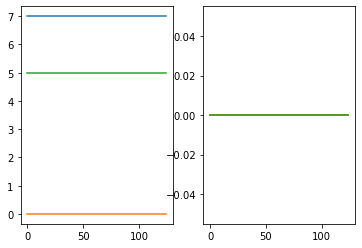

X_train[16207]: no_activity


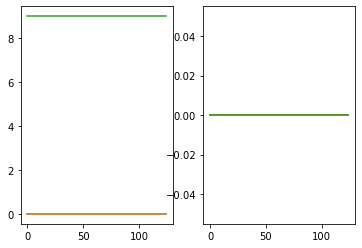

X_train[19759]: no_activity


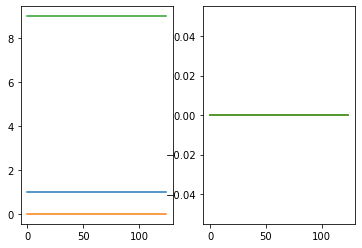

X_train[16595]: walk


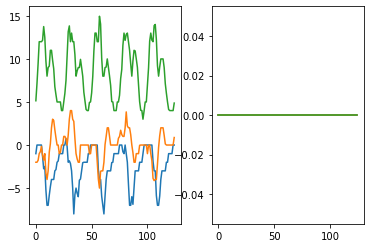

X_train[4530]: stairs


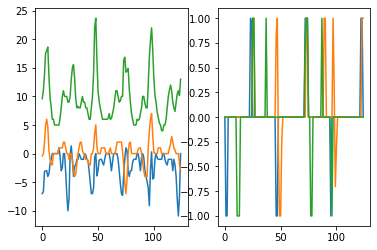

X_train[3684]: no_activity


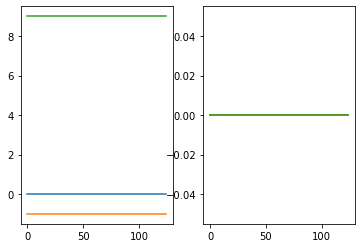

X_train[7088]: bike


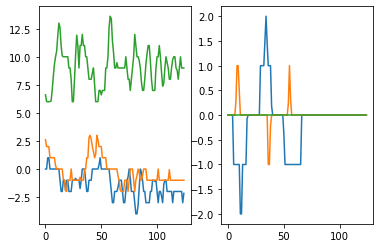

X_train[18268]: bike


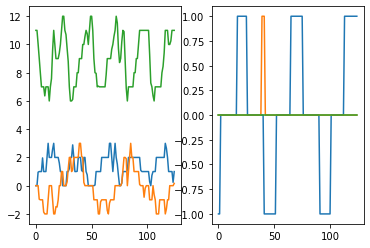

X_train[17490]: bike


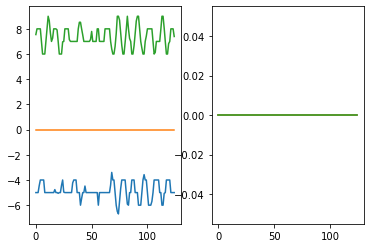

X_train[16034]: walk


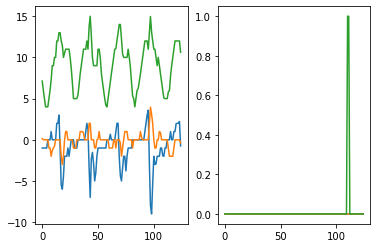

In [49]:
import random

for _ in range(10):
    i = random.randint(0, X_train.shape[0]) 
    x = X_train[i]

    print(f"X_train[{i}]: {y_train[i]}")
    plot_sensors(x)
    plt.show()

/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


<Figure size 432x288 with 0 Axes>

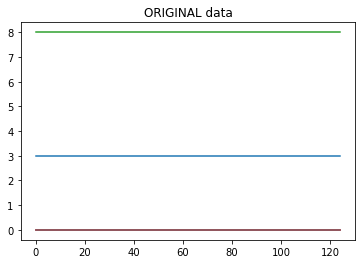

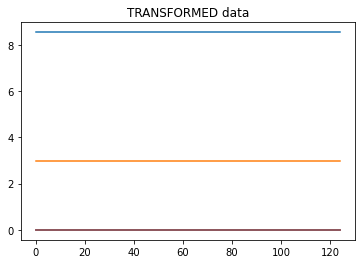

<Figure size 432x288 with 0 Axes>

In [47]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


def orientation_independent_transformation(data):

    data_transformed = []

    for sample in data:
        ax = sample[0]
        ay = sample[1]
        az = sample[2]
        gx = sample[3]
        gy = sample[4]
        gz = sample[5]

        gravity_vector = np.array([[np.mean(ax), np.mean(ay), np.mean(az)]]).T
        
        vertical_versor = gravity_vector / np.linalg.norm(gravity_vector, ord=2, axis=0) #(3,1)

        A = np.array([ax, ay, az]) # (3,125)
        G = np.array([gx, gy, gz]) # (3,125)

        # project data onto the vertical versor
        projected_vertical_acc = np.matmul(A.T, vertical_versor) #(125,1)
        projected_vertical_gyro = np.matmul(G.T, vertical_versor) #(125,1)

        A_floor = A - np.matmul(vertical_versor, projected_vertical_acc.T) 

        # APPLING PCA
        pca = PCA(n_components=1)
        pca.fit(A_floor.T)

        first_component = pca.components_.T

        horrizontal_versor = first_component / np.linalg.norm(first_component, ord=2, axis=0)
        
        projected_horrizontal_acc = np.matmul(A.T, horrizontal_versor)
        projected_horrizontal_gyro = np.matmul(G.T, horrizontal_versor)

        lateral_versor = np.cross(vertical_versor, horrizontal_versor, axis=0)
        
        projected_lateral_acc = np.matmul(A.T, lateral_versor)
        projected_lateral_gyro = np.matmul(G.T, lateral_versor)

        sample_transformed = np.array([projected_vertical_acc.T, projected_horrizontal_acc.T, projected_lateral_acc.T, projected_vertical_gyro.T, projected_horrizontal_gyro.T, projected_lateral_gyro.T ]).reshape((6,125))

        data_transformed.append(sample_transformed)
    
    return np.array(data_transformed)
        


example_transformed = orientation_independent_transformation(X_train[:12])

plt.plot(X_train[11].T)
plt.title('ORIGINAL data')
plt.figure()

plt.plot(example_transformed[11].T)
plt.title('TRANSFORMED data')
plt.figure()

## Data Exploration

In [50]:
print("Users", y_df["user"].unique())
print("Models", y_df["model"].unique())
print("Classes", y_df["label"].unique())

Users ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i']
Models ['nexus4_1' 'nexus4_2' 's3_1' 's3_2' 's3mini_1' 's3mini_2']
Classes ['no_activity' 'walk' 'stairs' 'bike']


Fraction of samples per label

In [51]:
print(y_df.groupby(["label"])["label"].count() / y_df["label"].count())

label
bike           0.139714
no_activity    0.368941
stairs         0.269600
walk           0.221745
Name: label, dtype: float64


Fraction of samples per user

In [52]:
print(y_df.groupby(["user"])["user"].count() / y_df["user"].count())

user
a    0.113949
b    0.115366
c    0.101465
d    0.114480
e    0.120413
f    0.094781
g    0.113285
h    0.107353
i    0.118907
Name: user, dtype: float64


Fraction of samples per model

In [53]:
print(y_df.groupby(["model"])["model"].count() / y_df["model"].count())

model
nexus4_1    0.198105
nexus4_2    0.211342
s3_1        0.187171
s3_2        0.206029
s3mini_1    0.190137
s3mini_2    0.007216
Name: model, dtype: float64


Number of samples per user i and fraction of samples per class for user i

In [54]:
y_df_i = y_df.loc[y_df["user"] == "i"]

num_samples_i = y_df_i["label"].count()
fraction_of_samples_per_class_i = y_df_i.groupby(["label"])["label"].count() / y_df_i["label"].count()

print(num_samples_i)
print(fraction_of_samples_per_class_i)

2686
label
bike           0.164557
no_activity    0.380491
stairs         0.218541
walk           0.236411
Name: label, dtype: float64


X_test[0]: bike


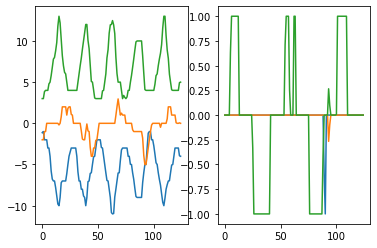

X_test[1]: bike


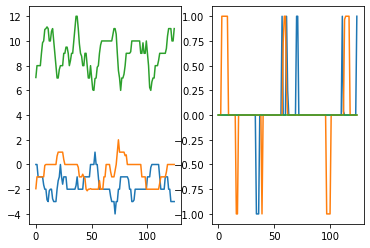

X_test[6]: bike


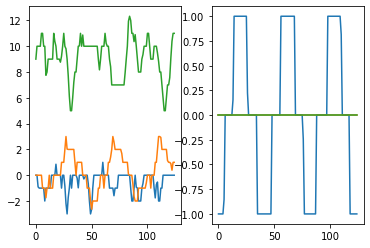

X_test[14]: bike


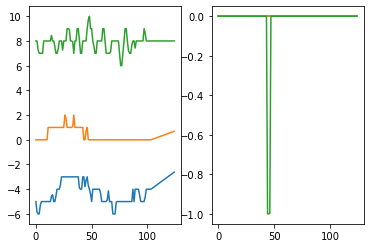

X_test[24]: bike


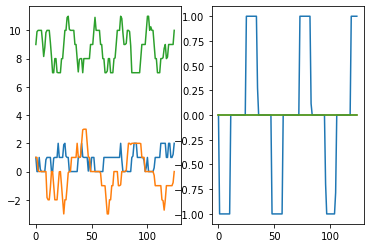

X_test[37]: bike


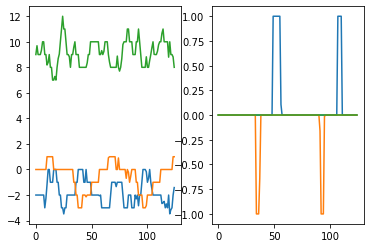

X_test[39]: bike


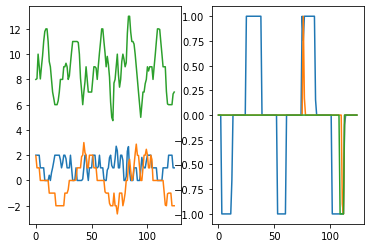

X_test[41]: bike


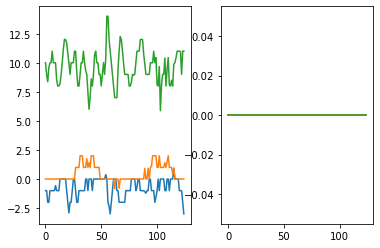

X_test[43]: bike


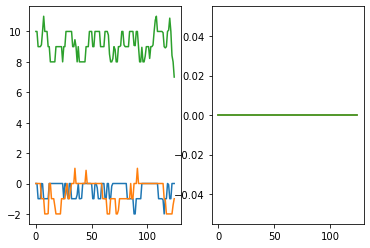

X_test[48]: bike


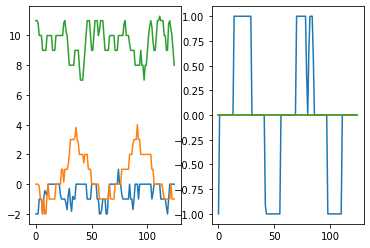

X_test[56]: bike


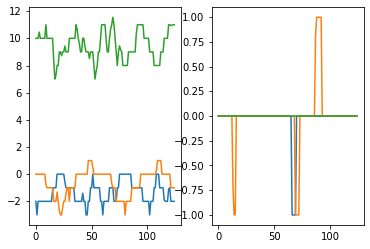

In [55]:
counter = 0
num = 10

for i in range(len(y_train)):
    if counter > num:
        break

    y = y_train[i]

    if y != "bike":
        continue 
    
    x = X_train[i]
    print(f"X_test[{i}]: {y_train[i]}")
    plot_sensors(x)
    plt.show()

    counter += 1

## Helpers

In [56]:
def get_name(i):
    assert i >= 0 and i <= 5, f"Component {i} is not supported, must be between 0 and 5"
    names = ["x_acc", "y_acc", "z_acc", "x_gyro", "y_gyro", "z_gyro"]

    return names[i]

def plot_reconstruction_error(sample, reconstruction):

    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.title(get_name(i))

        plt.plot(sample[i],'b')
        plt.plot(reconstruction[i], 'r')
        plt.fill_between(np.arange(125), reconstruction[i], sample[i], color='lightcoral' )

    plt.legend(labels=["sample", "reconstruction", "error"])


def visualize(sample, code, reconstruction):
    plt.subplot(1, 5, 1)
    plt.title("acc original")
    plot_acc(sample)

    plt.subplot(1, 5, 2)
    plt.title("gyro original")
    plot_gyro(sample)

    plt.subplot(1, 5, 3)
    plt.title("code")
    plt.imshow(code)

    plt.subplot(1, 5, 4)
    plt.title("acc reconstructed")
    plot_acc(reconstruction)

    plt.subplot(1, 5, 5)
    plt.title("gyro reconstructed")
    plot_gyro(reconstruction)


In [57]:
def plot_loss(history):
    h = history.history
    plt.plot(h["loss"], label="loss")
    plt.plot(h["val_loss"], label="val_loss")
    plt.legend()
    plt.show()

In [58]:
def split_acc_gyro(data):
    acc_data = np.array(list(map(lambda x: x[:3], data)))
    gyro_data = np.array(list(map(lambda x: x[3:], data)))

    assert len(data) == len(acc_data) == len(gyro_data)

    return acc_data, gyro_data

def merge_acc_gyro(acc_data, gyro_data):
    return np.array(list(map(lambda x: np.append(x[0], x[1]), zip(acc_data, gyro_data))))

## Model (autoencoder)

In [204]:
def show_some(X, y, n=10):
    for i in range(n):
        x = X_train_oit[i]

        print(f"X_train_oit[{i}]: {y_train[i]}")
        plot_sensors(x)
        plt.show()

#show_some(X, y)

In [205]:
DATA_SHAPE = X_train_oit.shape[1:]
CODE_SIZE=36

In [206]:
def build_encoder(data_shape, code_size):
    inputs = tf.keras.Input(data_shape)
    X = layers.Flatten()(inputs)
    outputs = layers.Dense(code_size, activation="sigmoid")(X)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [207]:

def build_decoder(data_shape, code_size):
    inputs = tf.keras.Input((code_size,))
    X = layers.Dense(np.prod(data_shape), activation=None)(inputs)
    outputs = layers.Reshape(data_shape)(X)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [208]:
encoder = build_encoder(DATA_SHAPE, CODE_SIZE)
decoder = build_decoder(DATA_SHAPE, CODE_SIZE)

In [209]:
def build_autoencoder(encoder, decoder):
    inputs = tf.keras.Input(DATA_SHAPE)  # input
    codes = encoder(inputs)              # build the code with the encoder
    outputs = decoder(codes)             # reconstruction the signal with the decoder

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [210]:
autoencoder = build_autoencoder(encoder, decoder)

optimizer = "adam"
loss = "mse"

model_filename = 'autoencoder_network.hdf5'
last_finished_epoch = None
epochs=30
batch_size=40

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
save_model_checkpoint_callback = keras_utils.ModelSaveCallback(model_filename)

callbacks = [save_model_checkpoint_callback, early_stopping_callback]

autoencoder.compile(optimizer=optimizer, loss=loss)

history = autoencoder.fit(
    x=X_train_oit, y=X_train_oit, 
    epochs=epochs, 
    validation_data=(X_test_oit, X_test_oit), 
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1, 
    initial_epoch=last_finished_epoch or 0)

Epoch 1/30
498/498 [==============================] - 1s 2ms/step - loss: 4.6576 - val_loss: 1.4690
Epoch 2/30
498/498 [==============================] - 1s 2ms/step - loss: 1.6235 - val_loss: 1.3392
Epoch 3/30
498/498 [==============================] - 1s 2ms/step - loss: 1.5806 - val_loss: 1.2487
Epoch 4/30
498/498 [==============================] - 1s 2ms/step - loss: 1.4937 - val_loss: 1.1235
Epoch 5/30
498/498 [==============================] - 1s 1ms/step - loss: 1.4324 - val_loss: 1.0193
Epoch 6/30
498/498 [==============================] - 1s 2ms/step - loss: 1.3880 - val_loss: 0.9268
Epoch 7/30
498/498 [==============================] - 1s 1ms/step - loss: 1.3250 - val_loss: 0.8574
Epoch 8/30
498/498 [==============================] - 1s 2ms/step - loss: 1.2771 - val_loss: 0.8035
Epoch 9/30
498/498 [==============================] - 1s 2ms/step - loss: 1.2438 - val_loss: 0.7736
Epoch 10/30
498/498 [==============================] - 1s 2ms/step - loss: 1.2132 - val_loss: 0.7485

In [211]:
h = history.history

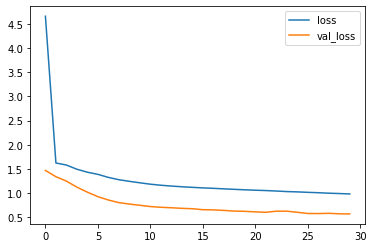

In [212]:
plt.plot(h['loss'], label="loss")
plt.plot(h['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [213]:
print("MSE =", autoencoder.evaluate(X_test_oit, X_test_oit, verbose=0))

MSE = 0.5699796676635742


In [214]:
def show_autoencoder_internals():
    for i in range(10):
        sample = X_test_oit[i]
        code = encoder.predict(sample[np.newaxis, :])[0]
        reconstruction = decoder.predict(code[np.newaxis, :])[0]
        
        plt.figure(figsize=(12,3))
        visualize(sample=sample, code=code.reshape(CODE_SIZE // 6, 6), reconstruction=reconstruction)
        plt.show()

#show_autoencoder_internals()

In [215]:
def show_reconstruction_error():
    samples = X_test_oit[:10]
    codes = encoder.predict(samples)
    reconstructions = decoder.predict(codes)

    for i in range(10):
        sample = samples[i]
        reconstruction = reconstructions[i]

        plt.figure(figsize=(12,8))
        plot_reconstruction_error(sample, reconstruction)
        plt.show()

#show_reconstruction_error()

Show the recostruction error only for bike as it is the class with lowest accuracy

In [216]:
def show_reconstruction_error_for_bike():
    counter = 0
    num = 10

    for i in range(len(y_test)):
        if counter > num:
            break

        y = y_test[i]

        if y != "bike":
            continue 
        
        x = X_test_oit[i]
        print(f"X_test[{i}]: {y_test[i]}")
        
        sample = X_test[i]
        code = encoder.predict(sample[np.newaxis, :])[0]
        reconstruction = decoder.predict(code[np.newaxis, :])[0]
        
        plt.figure(figsize=(12,8))
        plot_reconstruction_error(sample, reconstruction)
        plt.show()

        counter += 1

#show_reconstruction_error_for_bike()

Evaluate model by clustering features

In [219]:
from sklearn.neighbors import KNeighborsClassifier

# prepare the codes
codes = encoder.predict(X_train_oit)

assert codes.shape[1:] == (CODE_SIZE,), f"Predicted codes shape must be equal to code size, but {codes.shape[1:]} != {(CODE_SIZE,)}"

# create the k-neighbors calssifier
n_neighbors = 5
metric = "euclidean"

nbrs = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)

# fit the model using the codes
nbrs.fit(codes, y_train)

KNeighborsClassifier(metric='euclidean')

In [220]:
print("Classes =", nbrs.classes_)

Classes = ['bike' 'no_activity' 'stairs' 'walk']


In [221]:
print("X_test_oit[i] = y_true \t y_pred    \t with probs [...]")
print()

for i in range(20):
    x = X_test_oit[i]
    y = y_test[i]

    c = encoder.predict(x[np.newaxis, :])[0]
    
    [lab] = nbrs.predict(c[np.newaxis, :])
    [probs] = nbrs.predict_proba(c[np.newaxis, :])

    print(f"X_test[{i}] = {y}\t {lab}   \t with probs {probs}")


X_test_oit[i] = y_true 	 y_pred    	 with probs [...]

X_test[0] = no_activity	 no_activity   	 with probs [0. 1. 0. 0.]
X_test[1] = no_activity	 no_activity   	 with probs [0. 1. 0. 0.]
X_test[2] = walk	 walk   	 with probs [0.  0.  0.4 0.6]
X_test[3] = stairs	 stairs   	 with probs [0.4 0.  0.6 0. ]
X_test[4] = stairs	 bike   	 with probs [0.6 0.4 0.  0. ]
X_test[5] = walk	 walk   	 with probs [0.  0.  0.4 0.6]
X_test[6] = no_activity	 no_activity   	 with probs [0. 1. 0. 0.]
X_test[7] = walk	 walk   	 with probs [0.  0.  0.2 0.8]
X_test[8] = walk	 walk   	 with probs [0.  0.  0.4 0.6]
X_test[9] = stairs	 stairs   	 with probs [0.2 0.  0.8 0. ]
X_test[10] = no_activity	 no_activity   	 with probs [0. 1. 0. 0.]
X_test[11] = no_activity	 no_activity   	 with probs [0. 1. 0. 0.]
X_test[12] = stairs	 stairs   	 with probs [0. 0. 1. 0.]
X_test[13] = stairs	 walk   	 with probs [0.  0.  0.4 0.6]
X_test[14] = bike	 no_activity   	 with probs [0. 1. 0. 0.]
X_test[15] = no_activity	 no_activi

In [224]:
from sklearn.metrics import classification_report

codes = encoder.predict(X_test_oit)

y_true = y_test
y_pred = nbrs.predict(codes)

print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

        bike       0.63      0.59      0.61       442
 no_activity       0.86      1.00      0.92      1022
      stairs       0.51      0.71      0.59       587
        walk       0.91      0.39      0.55       635

    accuracy                           0.73      2686
   macro avg       0.73      0.67      0.67      2686
weighted avg       0.76      0.73      0.71      2686



In [222]:
raise 1

TypeError: exceptions must derive from BaseException

## Model (acc/gyro data splitted)

In [124]:
X_train_acc, X_train_gyro = split_acc_gyro(X_train)
X_test_acc, X_test_gyro = split_acc_gyro(X_test)

print("X_train_acc.shape =", X_train_acc.shape)
print("X_test_acc.shape =", X_test_acc.shape)
print("X_train_gyro.shape =", X_train_gyro.shape)
print("X_test_gyro.shape =", X_test_gyro.shape)

X_train_acc.shape = (19903, 3, 125)
X_test_acc.shape = (2686, 3, 125)
X_train_gyro.shape = (19903, 3, 125)
X_test_gyro.shape = (2686, 3, 125)


In [125]:
DATA_SHAPE = X_train_acc.shape[1:]
CODE_SIZE_ACC = 36
CODE_SIZE_GYRO = 18

In [126]:
optimizer = "adam"
loss = "mse"

model_filename = 'autoencoder_network.hdf5'
last_finished_epoch = None
epochs=50
batch_size=128

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
save_model_checkpoint_callback = keras_utils.ModelSaveCallback(model_filename)

callbacks = [save_model_checkpoint_callback, early_stopping_callback]

In [127]:
encoder_acc = build_encoder(DATA_SHAPE, CODE_SIZE_ACC)
decoder_acc = build_decoder(DATA_SHAPE, CODE_SIZE_ACC)

autoencoder_acc = build_autoencoder(encoder_acc, decoder_acc)

autoencoder_acc.compile(optimizer=optimizer, loss=loss)

history = autoencoder_acc.fit(
    x=X_train_acc, y=X_train_acc, 
    epochs=epochs, 
    validation_data=(X_test_acc, X_test_acc), 
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1, 
    initial_epoch=last_finished_epoch or 0)

Epoch 1/50
156/156 [==============================] - 0s 2ms/step - loss: 18.0206 - val_loss: 9.9317
Epoch 2/50
156/156 [==============================] - 0s 2ms/step - loss: 6.9518 - val_loss: 4.3313
Epoch 3/50
156/156 [==============================] - 0s 2ms/step - loss: 4.4061 - val_loss: 2.7056
Epoch 4/50
156/156 [==============================] - 0s 2ms/step - loss: 3.5400 - val_loss: 2.0951
Epoch 5/50
156/156 [==============================] - 0s 2ms/step - loss: 3.1494 - val_loss: 1.8125
Epoch 6/50
156/156 [==============================] - 0s 2ms/step - loss: 2.9170 - val_loss: 1.6691
Epoch 7/50
156/156 [==============================] - 0s 2ms/step - loss: 2.8184 - val_loss: 1.6303
Epoch 8/50
156/156 [==============================] - 0s 2ms/step - loss: 2.7699 - val_loss: 1.6084
Epoch 9/50
156/156 [==============================] - 0s 2ms/step - loss: 2.7323 - val_loss: 1.5973
Epoch 10/50
156/156 [==============================] - 0s 2ms/step - loss: 2.6959 - val_loss: 1.574

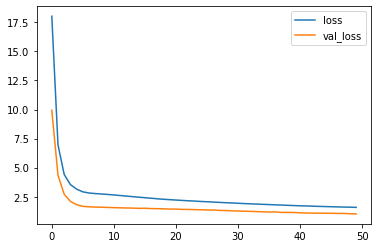

In [128]:
plot_loss(history)

In [129]:


encoder_gyro = build_encoder(DATA_SHAPE, CODE_SIZE_GYRO)
decoder_gyro = build_decoder(DATA_SHAPE, CODE_SIZE_GYRO)

autoencoder_gyro = build_autoencoder(encoder_gyro, decoder_gyro)

autoencoder_gyro.compile(optimizer=optimizer, loss=loss)

history = autoencoder_gyro.fit(
    x=X_train_gyro, y=X_train_gyro,
    epochs=epochs, 
    validation_data=(X_test_gyro, X_test_gyro), 
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1, 
    initial_epoch=last_finished_epoch or 0)

Epoch 1/50
156/156 [==============================] - 0s 2ms/step - loss: 0.0668 - val_loss: 0.0090
Epoch 2/50
156/156 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0069
Epoch 3/50
156/156 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0061
Epoch 4/50
156/156 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0057
Epoch 5/50
156/156 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.0054
Epoch 6/50
156/156 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0052
Epoch 7/50
156/156 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0051
Epoch 8/50
156/156 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0050
Epoch 9/50
156/156 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0048
Epoch 10/50
156/156 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0047

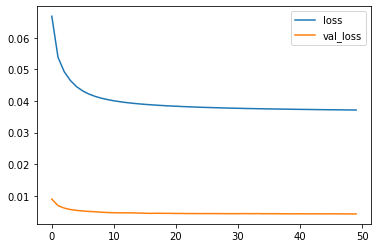

In [130]:
plot_loss(history)

Merge encoder in class

In [131]:
loss_acc = autoencoder_acc.evaluate(X_test_acc, X_test_acc, verbose=0)
loss_gyro = autoencoder_gyro.evaluate(X_test_gyro, X_test_gyro, verbose=0)
print("MSE ACC:", loss_acc)
print("MSE GYRO:", loss_gyro)

MSE ACC: 1.019615888595581
MSE GYRO: 0.004275224171578884


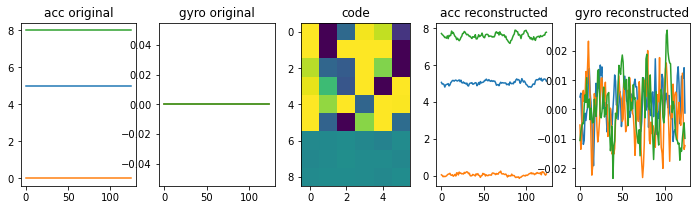

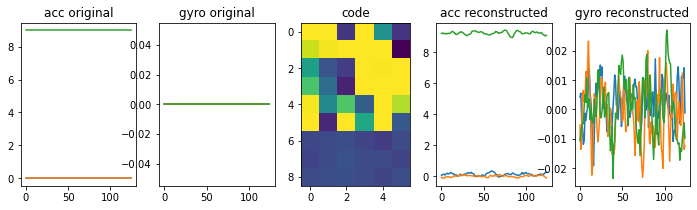

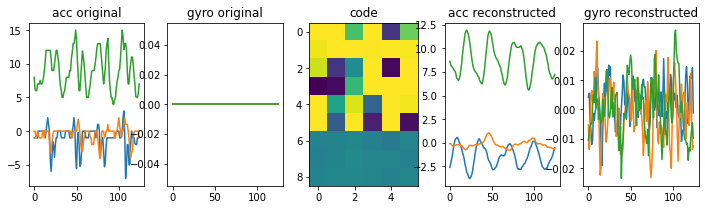

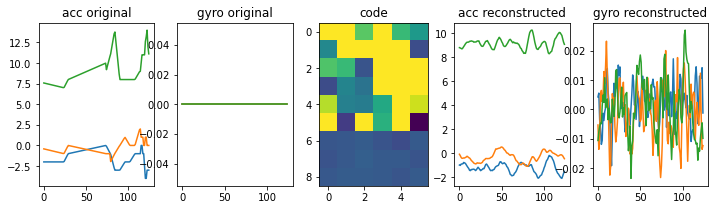

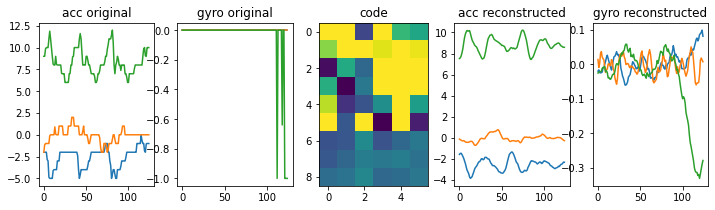

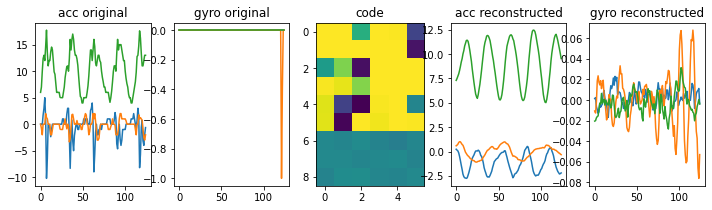

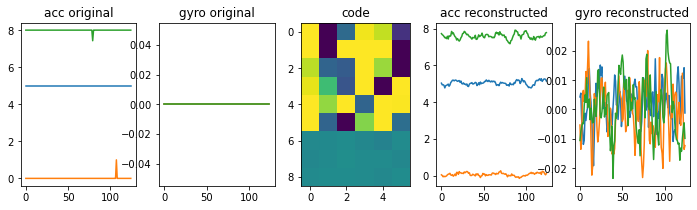

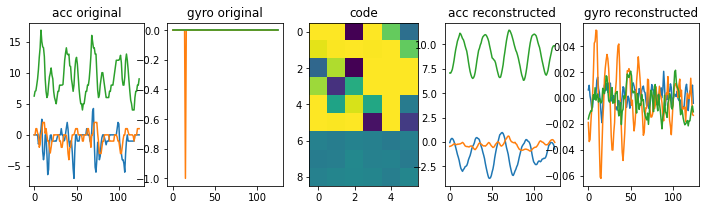

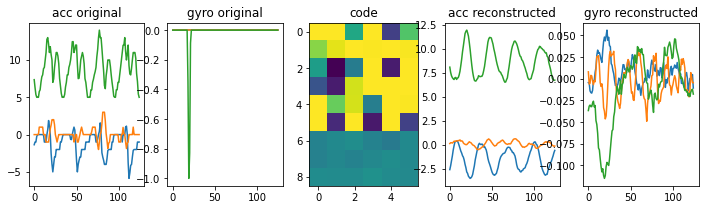

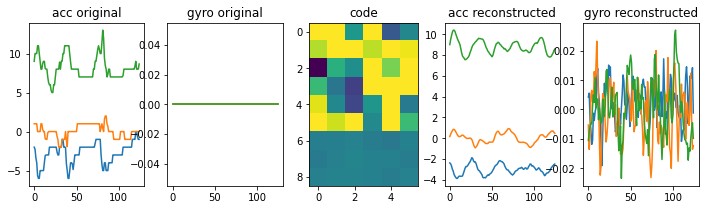

In [132]:
for i in range(10):
    sample_acc = X_test_acc[i]
    sample_gyro = X_test_gyro[i]

    code_acc = encoder_acc.predict(sample_acc[np.newaxis, :])[0]
    code_gyro = encoder_gyro.predict(sample_gyro[np.newaxis, :])[0]

    reconstruction_acc = decoder_acc.predict(code_acc[np.newaxis, :])[0]
    reconstruction_gyro = decoder_gyro.predict(code_gyro[np.newaxis, :])[0]
    
    sample = np.append(sample_acc, sample_gyro).reshape((6,125))
    code = np.append(code_acc, code_gyro).reshape(((CODE_SIZE_ACC+CODE_SIZE_GYRO)//6,6))
    reconstruction = np.append(reconstruction_acc, reconstruction_gyro).reshape((6,125))

    plt.figure(figsize=(12,3))
    visualize(sample=sample, code=code, reconstruction=reconstruction)
    plt.show()

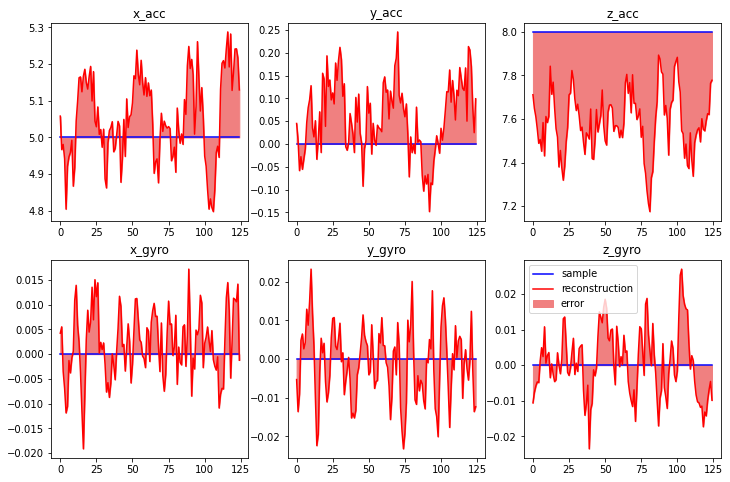

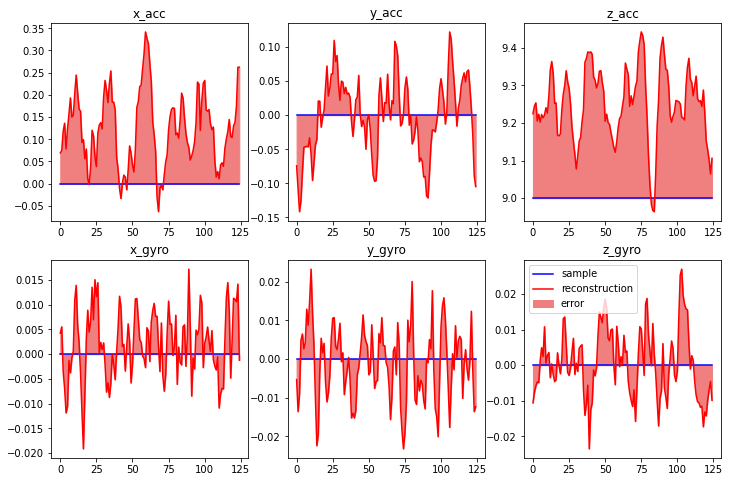

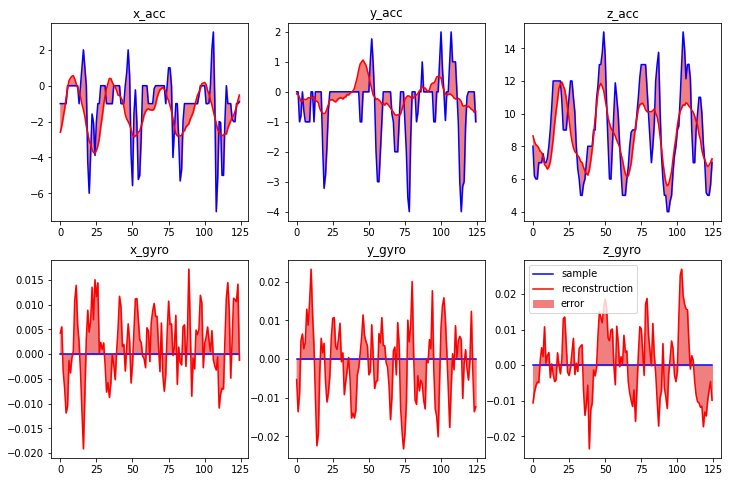

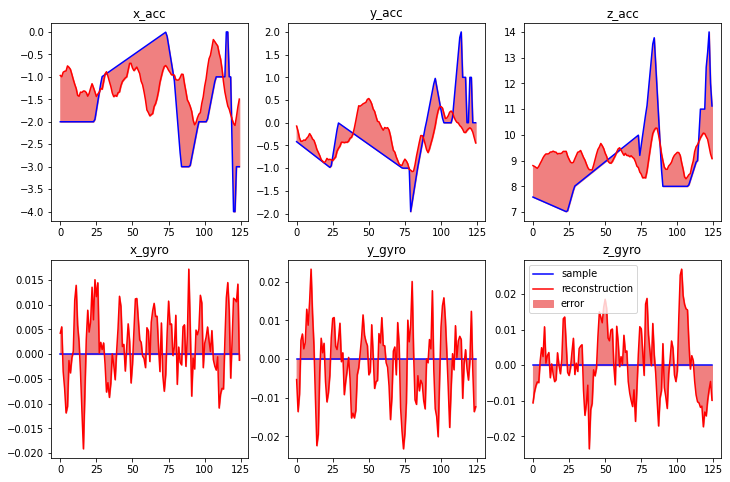

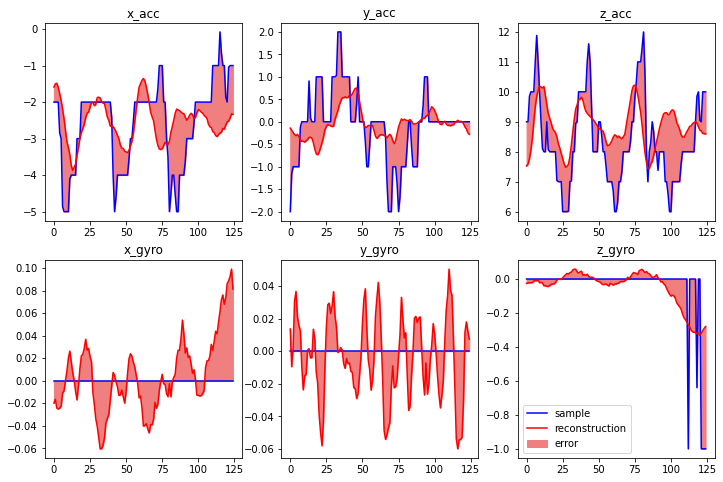

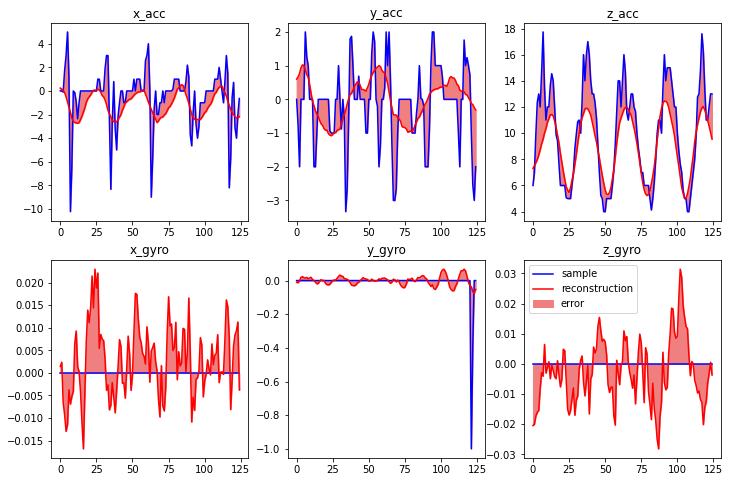

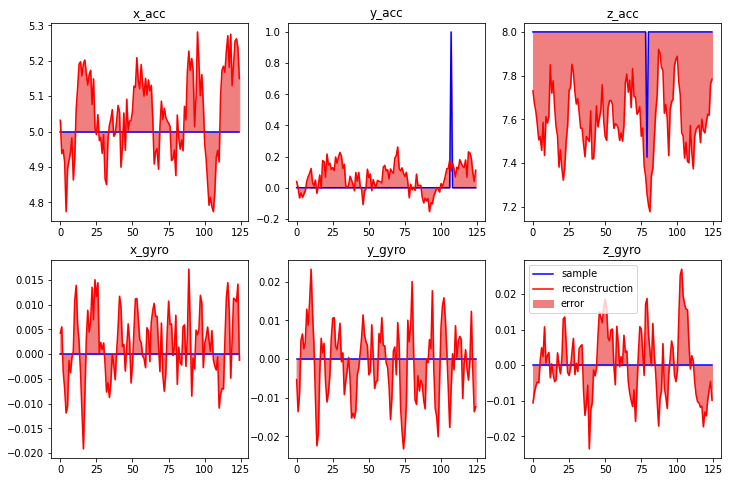

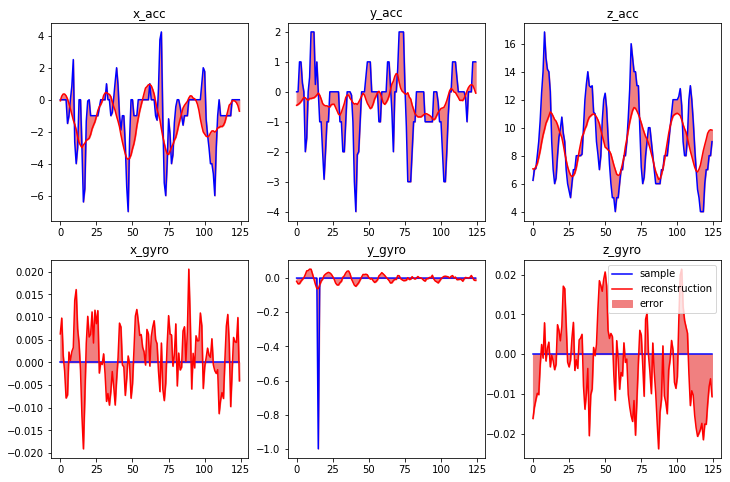

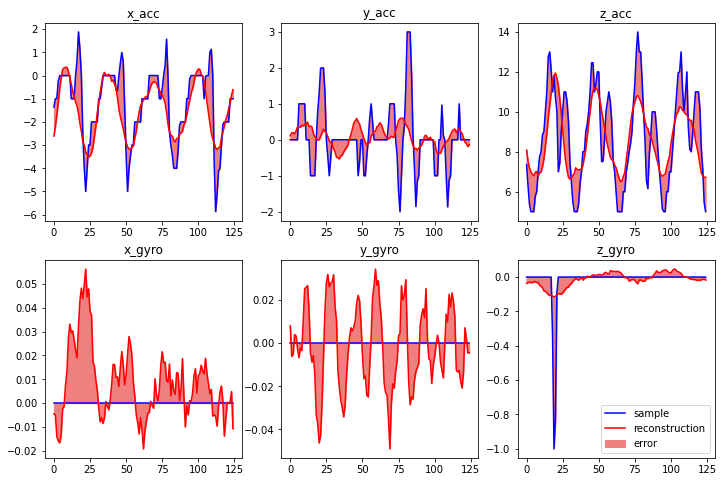

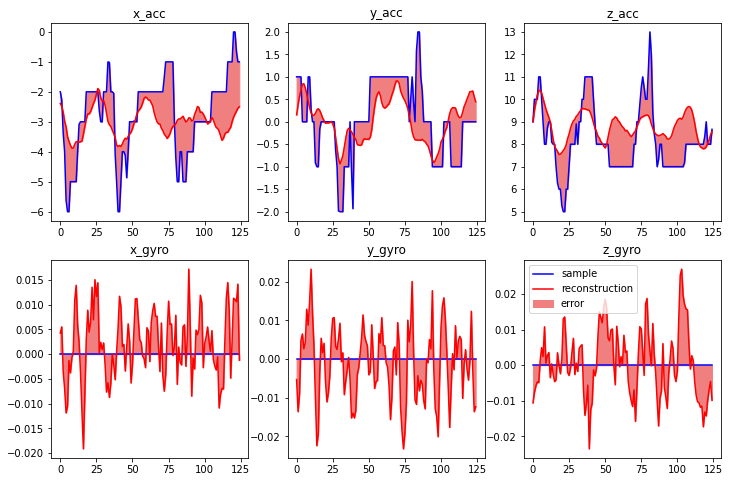

In [134]:
for i in range(10):
    sample_acc = X_test_acc[i]
    sample_gyro = X_test_gyro[i]

    code_acc = encoder_acc.predict(sample_acc[np.newaxis, :])[0]
    code_gyro = encoder_gyro.predict(sample_gyro[np.newaxis, :])[0]

    reconstruction_acc = decoder_acc.predict(code_acc[np.newaxis, :])[0]
    reconstruction_gyro = decoder_gyro.predict(code_gyro[np.newaxis, :])[0]
    
    sample = np.append(sample_acc, sample_gyro).reshape((6,125))
    code = np.append(code_acc, code_gyro).reshape(((CODE_SIZE_ACC+CODE_SIZE_GYRO)//6,6))
    reconstruction = np.append(reconstruction_acc, reconstruction_gyro).reshape((6,125))

    plt.figure(figsize=(12,8))
    plot_reconstruction_error(sample, reconstruction)
    plt.show()

We apply a lowpass filter to reconstructed signal to avoid oscillations

In [136]:
from scipy.signal import butter, filtfilt, freqz
import matplotlib.pyplot as plt

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [138]:
def plot_butter_lowpass_filter(cutoff, fs, order):
    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_lowpass(cutoff, fs, order)

    # Plot the frequency response.
    w, h = freqz(b, a, worN=8000)
    plt.subplot(2, 1, 1)
    plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
    plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
    plt.axvline(cutoff, color='k')
    plt.xlim(0, 0.5*fs)
    plt.title("Lowpass Filter Frequency Response")
    plt.xlabel('Frequency [Hz]')
    plt.grid()


Setting the filter parameters and plotting it

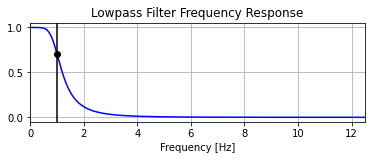

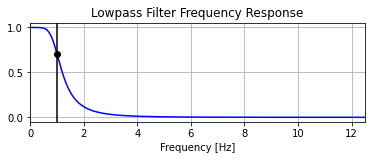

In [140]:
cutoff_acc = 1  # desired cutoff frequency of the filter, Hz
fs_acc = 25      # sample rate, Hz
order_acc = 3

cutoff_gyro = 1  # desired cutoff frequency of the filter, Hz
fs_gyro = 25     # sample rate, Hz
order_gyro = 3

plot_butter_lowpass_filter(cutoff_acc, fs_acc, order_acc)
plt.show()
plot_butter_lowpass_filter(cutoff_gyro, fs_gyro, order_gyro)
plt.show()

Show some examples of reconstructed and filtered signals

X_test[0] = no_activity


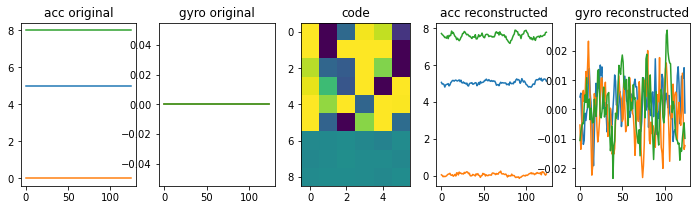

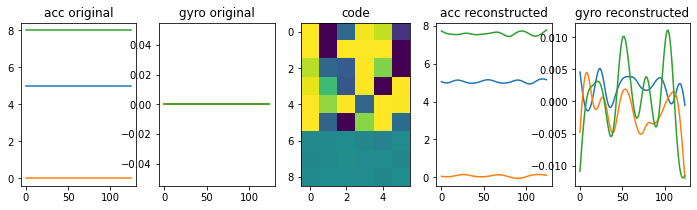

In [142]:
for i in range(1):
    sample_acc = X_test_acc[i]
    sample_gyro = X_test_gyro[i]

    code_acc = encoder_acc.predict(sample_acc[np.newaxis, :])[0]
    code_gyro = encoder_gyro.predict(sample_gyro[np.newaxis, :])[0]

    reconstruction_acc = decoder_acc.predict(code_acc[np.newaxis, :])[0]
    reconstruction_gyro = decoder_gyro.predict(code_gyro[np.newaxis, :])[0]

    reconstruction_acc_filtered = np.array(list(map(lambda x: butter_lowpass_filter(x, cutoff_acc, fs_acc, order_acc), reconstruction_acc)))
    reconstruction_gyro_filtered = np.array(list(map(lambda x: butter_lowpass_filter(x, cutoff_gyro, fs_gyro, order_gyro), reconstruction_gyro)))
    
    sample = np.append(sample_acc, sample_gyro).reshape((6,125))
    code = np.append(code_acc, code_gyro).reshape(((CODE_SIZE_ACC+CODE_SIZE_GYRO)//6,6))
    reconstruction = np.append(reconstruction_acc, reconstruction_gyro).reshape((6,125))
    reconstruction_filtered = np.append(reconstruction_acc_filtered, reconstruction_gyro_filtered).reshape((6,125))

    print(f"X_test[{i}] = {y_test[i]}")

    plt.figure(figsize=(12,3))
    visualize(sample=sample, code=code, reconstruction=reconstruction)
    plt.show()

    plt.figure(figsize=(12,3))
    visualize(sample=sample, code=code, reconstruction=reconstruction_filtered)
    plt.show()

How to evaluate the autoencoder now?

In [144]:
# We need to evaluate the autoencoder on the filtered reconstructed signal

#reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
#print("Convolutional autoencoder MSE:", reconstruction_mse)

## Clustering

In [146]:
from sklearn.neighbors import KNeighborsClassifier

# prepare the codes
codes_acc = encoder_acc.predict(X_train_acc)
codes_gyro = encoder_gyro.predict(X_train_gyro)

assert len(codes_acc) == len(codes_gyro)

codes = np.array([])

for i in range(len(codes_acc)):
    ca = codes_acc[i]
    cg = codes_gyro[i]

    c = np.append(ca, cg)
    codes = np.append(codes, c)

codes = codes.reshape(len(codes_acc), 36+18)
print(codes.shape)

assert len(codes) == len(X_train_acc), f"Codes len ({len(codes)}) is not equal to X_train_acc len ({len(X_train_acc)})"

# create the k-neighbors calssifier
n_neighbors = 5
metric = "euclidean"

nbrs = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)

# fit the model using the codes
nbrs.fit(codes, y_train)

(19903, 54)


KNeighborsClassifier(metric='euclidean')

Now for some example we want to see if the classifier is predicting the correct label

In [148]:
print("Classes =", nbrs.classes_)

Classes = ['bike' 'no_activity' 'stairs' 'walk']


In [150]:
print("X_test[i] = y_true \t y_pred    \t with probs [...]")
print()

for i in range(20):
    xa = X_test_acc[i]
    xg = X_test_gyro[i]
    y = y_test[i]

    c_acc = encoder_acc.predict(xa[np.newaxis, :])[0]
    c_gyro = encoder_gyro.predict(xg[np.newaxis, :])[0]
    c = np.append(c_acc, c_gyro)

    [lab] = nbrs.predict(c[np.newaxis, :])
    [probs] = nbrs.predict_proba(c[np.newaxis, :])

    print(f"X_test[{i}] = {y}\t {lab}   \t with probs {probs}")

#for i in range(20):
#    x = X_test_gyro[i]
#    y = y_test[i]
#
#    c = encoder_gyro.predict(x[np.newaxis, :])[0]
#    
#    [lab] = nbrs_gyro.predict(c[np.newaxis, :])
#    [probs] = nbrs_gyro.predict_proba(c[np.newaxis, :])
#
#    print(f"X_test[{i}] = {y}\t {lab}   \t with probs {probs}")

X_test[i] = y_true 	 y_pred    	 with probs [...]

X_test[0] = no_activity	 bike   	 with probs [1. 0. 0. 0.]
X_test[1] = no_activity	 no_activity   	 with probs [0. 1. 0. 0.]
X_test[2] = walk	 walk   	 with probs [0. 0. 0. 1.]
X_test[3] = stairs	 bike   	 with probs [0.6 0.4 0.  0. ]
X_test[4] = stairs	 bike   	 with probs [1. 0. 0. 0.]
X_test[5] = walk	 walk   	 with probs [0. 0. 0. 1.]
X_test[6] = no_activity	 bike   	 with probs [1. 0. 0. 0.]
X_test[7] = walk	 stairs   	 with probs [0.  0.  0.8 0.2]
X_test[8] = walk	 walk   	 with probs [0. 0. 0. 1.]
X_test[9] = stairs	 no_activity   	 with probs [0.  0.4 0.4 0.2]
X_test[10] = no_activity	 no_activity   	 with probs [0. 1. 0. 0.]
X_test[11] = no_activity	 no_activity   	 with probs [0. 1. 0. 0.]
X_test[12] = stairs	 bike   	 with probs [0.4 0.  0.4 0.2]
X_test[13] = stairs	 stairs   	 with probs [0.  0.  0.8 0.2]
X_test[14] = bike	 no_activity   	 with probs [0. 1. 0. 0.]
X_test[15] = no_activity	 bike   	 with probs [1. 0. 0. 0.]


Let's take a look at the precision/recall of the classifier

In [152]:
from sklearn.metrics import classification_report

codes_acc = encoder_acc.predict(X_test_acc)
codes_gyro = encoder_gyro.predict(X_test_gyro)

codes = np.array([])

for i in range(len(codes_acc)):
    ca = codes_acc[i]
    cg = codes_gyro[i]

    c = np.append(ca, cg)
    codes = np.append(codes, c)

codes = codes.reshape(len(codes_acc), 36+18)

y_true = y_test
y_pred = nbrs.predict(codes)

print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

        bike       0.26      0.50      0.34       442
 no_activity       0.70      0.65      0.67      1022
      stairs       0.65      0.40      0.50       587
        walk       0.92      0.78      0.84       635

    accuracy                           0.60      2686
   macro avg       0.63      0.58      0.59      2686
weighted avg       0.67      0.60      0.62      2686



In [154]:
from sklearn.metrics import classification_report

codes = encoder_gyro.predict(X_test_gyro)

y_true = y_test
y_pred = nbrs_gyro.predict(codes)

print(classification_report(y_true=y_true, y_pred=y_pred))

NameError: name 'nbrs_gyro' is not defined

Clutesting with k-means

In [1066]:
from sklearn.cluster import KMeans

codes = encoder_acc.predict(X_train_acc)

kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(codes)

KMeans(n_clusters=4, random_state=0)

In [1067]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y_test)

codes = encoder_acc.predict(X_test_acc)

y_true = y_test
y_pred = kmeans.predict(codes)

print(classification_report(y_true=y_true, y_pred=le.inverse_transform(y_pred)))

              precision    recall  f1-score   support

        bike       0.00      0.00      0.00       442
 no_activity       0.21      0.43      0.28      1022
      stairs       0.00      0.00      0.00       587
        walk       0.00      0.00      0.00       635

    accuracy                           0.16      2686
   macro avg       0.05      0.11      0.07      2686
weighted avg       0.08      0.16      0.11      2686

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1068]:
for i in range(20):
    x = X_test_acc[i]
    y = y_test[i]

    c = encoder_acc.predict(x[np.newaxis, :])[0]
    
    lab = kmeans.predict(c[np.newaxis, :])
    [lab] = le.inverse_transform(lab)
    print(f"X_test[{i}] = {y}\t {lab}")

X_test[0] = no_activity	 walk
X_test[1] = no_activity	 walk
X_test[2] = no_activity	 no_activity
X_test[3] = no_activity	 no_activity
X_test[4] = stairs	 no_activity
X_test[5] = bike	 no_activity
X_test[6] = no_activity	 no_activity
X_test[7] = stairs	 no_activity
X_test[8] = walk	 no_activity
X_test[9] = no_activity	 walk
X_test[10] = bike	 no_activity
X_test[11] = walk	 no_activity
X_test[12] = stairs	 no_activity
X_test[13] = no_activity	 walk
X_test[14] = walk	 no_activity
X_test[15] = walk	 no_activity
X_test[16] = no_activity	 no_activity
X_test[17] = stairs	 no_activity
X_test[18] = walk	 no_activity
X_test[19] = bike	 no_activity
